## 1. Picture Recommend

In [1]:
import os 
import cv2
import numpy as np
import pandas as pd
from keras.preprocessing import image
from keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from keras.models import Sequential
from keras.layers import GlobalMaxPool2D
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import tensorflow as tf
# tf.config.optimizer.set_jit(True)  


In [2]:
IMAGE_DIR = "../fashion-dataset/fashion-dataset/images/"
CSV_PATH = "../fashion-dataset/fashion-dataset/styles.csv"

df = pd.read_csv(CSV_PATH, nrows=50000, on_bad_lines='skip', engine='python')


|部分|	說明|
|---|---|
|df["image_path"]|	取出每一列的圖片檔名（如 1234.jpg）|
|.apply(lambda x: ...)	|對每個檔名 x 做函式處理|
|os.path.join(IMAGE_DIR, x)	|組合出完整路徑，如 "./images/1234.jpg"|
|os.path.exists(...)	|判斷該圖檔是否真的存在|
|df[...]	|利用布林遮罩保留存在的那些資料列|
|.reset_index(drop=True)	|重排 index，避免原本的 index 雜亂|

In [3]:
df["image_path"] = df["id"].astype(str) + ".jpg"

In [4]:
df.head(5)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


In [4]:

df = df[df["image_path"].apply(lambda x : os.path.exists(os.path.join(IMAGE_DIR, x)))].reset_index(drop = True)

In [5]:
model = Sequential([ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224,3)),GlobalMaxPool2D()])
model.trainable = True

In [6]:
def get_embedding(img_path):
    img = image.image_utils.load_img(img_path,target_size=(224, 224))
    x = image.image_utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return model.predict(x).reshape(-1)


In [8]:
embeddings = []
image_paths = [] # 對應圖檔路徑



In [ ]:
for idx, row in df.iterrows():
    path = os.path.join(IMAGE_DIR, row["image_path"])
    emb = get_embedding(path)
    embeddings.append(emb)
    image_paths.append(path)

In [10]:
# np.save("embeddings.npy", embeddings)
# np.save("image_paths.npy", np.array(image_paths))
embeddings = np.load("embeddings.npy")


In [11]:
embeddings = np.array(embeddings)
print("Embeddings shape:", embeddings.shape)

Embeddings shape: (44419, 2048)


In [12]:
similarity_matrix = cosine_similarity(embeddings)

In [18]:
model.save("resnet50v2_embed_model")

INFO:tensorflow:Assets written to: resnet50v2_embed_model\assets


INFO:tensorflow:Assets written to: resnet50v2_embed_model\assets


In [14]:
loaded_model = tf.keras.models.load_model("resnet50_embed_model")


In [17]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
Total params: 23,564,800
Trainable params: 23,519,360
Non-trainable params: 45,440
_________________________________________________________________


In [15]:
def recommend(index, top_n=5):
    sim_scores = list(enumerate(similarity_matrix[index]))  # 只取 index 這一列
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    rec_indexes = [i[0] for i in sim_scores]

    # 顯示參考圖
    ref_img = cv2.imread(os.path.join(IMAGE_DIR, df.iloc[index]["image_path"]))
    plt.imshow(cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB))
    plt.title("Reference Image")
    plt.axis("off")
    plt.show()

    # 顯示推薦圖
    fig, axes = plt.subplots(1, top_n, figsize=(15, 5))
    for i, rec_idx in enumerate(rec_indexes):
        img_path = os.path.join(IMAGE_DIR, df.iloc[rec_idx]["image_path"])
        rec_img = cv2.imread(img_path)
        axes[i].imshow(cv2.cvtColor(rec_img, cv2.COLOR_BGR2RGB))
        axes[i].axis("off")
    plt.suptitle("Top {} Recommendations".format(top_n))
    plt.show()


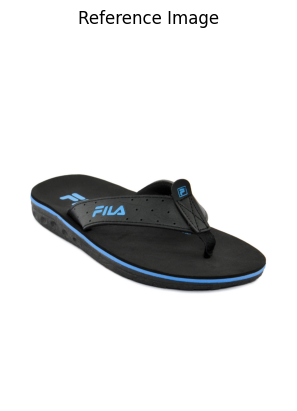

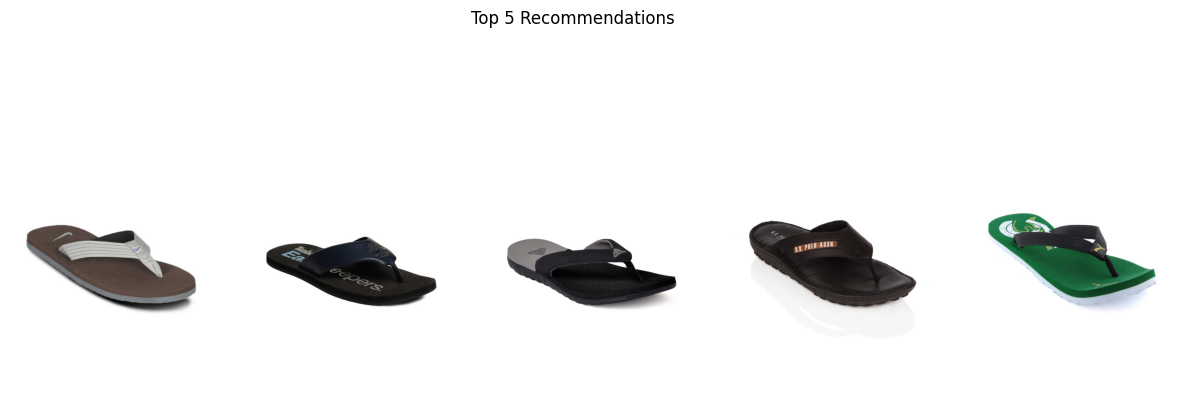

In [16]:
recommend(index=12, top_n=5)

## 2. Grab Color To Recommend

In [ ]:
from sklearn.cluster import KMeans
from collections import Counter

def get_dominant_color(img, k=3):
    # resize 加速
    img = cv2.resize(img,(50, 50))
    img = img.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(img)
    counts = Counter(kmeans.labels_)

    dominant = kmeans.cluster_centers_[counts.most_common(1)[0][0]]
    return tuple(map(int, dominant))



In [ ]:
def get_img_color_code(img_path):
    img = cv2.imread(img_path)
    if img is not None:
        return get_dominant_color(img,cv2.COLOR_BGR2RGB)
    else:
        return (0, 0, 0)
    


In [ ]:
df["dominant_color"] = df["image_path"].apply(lambda x: get_img_color_code(os.path.join(IMAGE_DIR, x)))


In [ ]:
from scipy.spatial import distance

def recommend_by_color(target_rgb, df, top_n=5):
    # 把顏色轉為 numpy 向量，計算距離
    df["color_dist"] = df["dominant_color"].apply(lambda rgb: distance.euclidean(rgb, target_rgb))
    df_sorted = df.sort_values("color_dist").iloc[:top_n]
    
    # 顯示結果
    fig, axes = plt.subplots(1, top_n, figsize=(15, 5))
    for i, row in enumerate(df_sorted.itertuples()):
        img = cv2.imread(os.path.join(IMAGE_DIR, row.image_path))
        axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        # axes[i].imshow(img)
        axes[i].axis("off")
    plt.suptitle("Items Closest to Color BGR color{}".format(target_rgb))
    plt.show()

In [ ]:
# recommend similar items
ref_img_path = os.path.join(IMAGE_DIR, df.iloc[0]["image_path"])
ref_color = get_img_color_code(ref_img_path)
recommend_by_color(ref_color, df, top_n=5)

# or looking for BGR
recommend_by_color((2, 2, 2), df, top_n=5)